# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import *

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/AllDataCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/AllDataSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#HF-ACTION
hfactionAllData = pd.read_csv("Data Validation/HF-ACTION/Original DataFrames/AllDataHF-ACTION.csv", sep=",", index_col='ID').sort_index()
hfactionLabels = pd.read_csv("Data Validation/HF-ACTION/Original DataFrames/LabelsHF-ACTION.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("Data Validation/BEST/Original DataFrames/AllDataBEST.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/AllDataGUIDE-IT.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


# Global Params

In [3]:
# Global Flags
pcaFlag = True
fitPredFlag = True

# Choose clutering model
# clusterModel = KMeans(n_clusters=5) #pred, PCA
clusterModel = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') #fitPred, PCA
# clusterModel = SpectralClustering(n_clusters=5, assign_labels='discretize') #fitPred, PCA
# clusterModel = Birch(n_clusters=5) #basically mini batch kmeans, pred, PCA

hemoModelName = 'Cluster_Hemo'
allDataModelName = 'Cluster_AllData'

# Group All Data Together

## HEMO

In [4]:
hemoOrig = escapeHemo.append(cardShockHemo)
hemoOrig = hemoOrig.append(serialHemo)
hemoOrig.index.name = 'ID'
hemoOrig

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PP,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,28.0,0.245614,0.428571,5357.575758,0.666667,0.266667,0.750000,0.777778,50.0,1.166667
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,24.0,0.235294,0.428571,3509.677419,0.750000,0.272727,1.000000,1.000000,50.0,1.333333
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,17.0,0.212500,0.500000,1982.300885,0.555556,0.242857,2.000000,0.944444,45.0,1.700000
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,40.0,0.470588,0.571429,1772.043011,0.705882,0.571429,1.666667,2.352941,45.0,3.333333
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,34.0,0.354167,0.627451,2621.138211,0.166667,0.566667,10.666667,1.888889,44.0,11.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z958018,55.0,2.0,NaN,NaN,20.0,45.0,20.0,29.0,20.0,1.97,...,45.0,0.412844,0.555556,5346.869712,1.000000,0.450000,1.250000,2.250000,44.0,2.250000
Z958018,55.0,2.0,NaN,NaN,6.0,43.0,19.0,30.0,20.0,3.20,...,45.0,0.412844,0.558140,3641.666667,0.300000,0.542169,4.000000,2.250000,44.0,7.500000
Z958018,55.0,2.0,NaN,NaN,12.0,47.0,26.0,35.0,32.0,0.93,...,45.0,0.412844,0.446809,12014.336918,0.375000,0.450000,1.750000,1.406250,32.0,3.750000


In [5]:
lst = []

for idx in hemoOrig.index:
    
    if idx in escapeLabels.index:
        row = escapeLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in cardShockHemoLabels.index:
        row = cardShockHemoLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    else: #serial hemo
        row = serialHemoLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
        
hemoLabels = pd.DataFrame(lst, columns=['ID','Death', 'Rehosp', 'Readmission']).set_index('ID', drop=True)
hemoLabels

,Death,Rehosp,Readmission
ID,,,
72,1,1.0,0.0
72,1,1.0,0.0
81,0,1.0,0.0
81,0,1.0,0.0
814,0,0.0,0.0
...,...,...,...
Z958018,0,NaN,NaN
Z958018,0,NaN,NaN
Z958018,0,NaN,NaN


## All Data

In [6]:
allDataOrig = escapeAllData.append(cardShockAllData)
allDataOrig = allDataOrig.append(serialAllData)
allDataOrig = allDataOrig.append(hfactionAllData)
allDataOrig = allDataOrig.append(bestAllData)
allDataOrig = allDataOrig.append(guideAllData)

allDataOrig.index.name = 'ID'
allDataOrig

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,DIUR,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,1.0,25.0,68.0,94.0,104.0,12.452563,139.333333,26.0,0.276596,0.250000
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,1.0,25.0,60.0,86.0,92.0,12.452563,126.000000,26.0,0.302326,0.282609
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,1.0,20.0,56.0,88.0,70.0,-3.346568,125.333333,32.0,0.363636,0.457143
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,1.0,20.0,43.0,77.0,72.0,-3.346568,105.666667,34.0,0.441558,0.472222
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,1.0,25.0,70.0,100.0,86.0,5.478621,146.666667,30.0,0.300000,0.348837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99676,74.0,1.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
99887,60.0,2.0,2.0,76.204300,24.105394,0.0,0.0,1.0,0.0,0.0,...,1.0,10.0,88.0,132.0,0.0,0.000000,190.666667,44.0,0.333333,0.463158
99887,60.0,2.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN


In [7]:
lst = []

for idx in allDataOrig.index:
    
    if idx in escapeLabels.index:
        row = escapeLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in cardShockLabels.index:
        row = cardShockLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in serialLabels.index:
        row = serialLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in hfactionLabels.index:
        row = hfactionLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in bestLabels.index:
        row = bestLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    else: #guide
        row = guideLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
        
allDataLabels = pd.DataFrame(lst, columns=['ID','Death', 'Rehosp', 'Readmission']).set_index('ID', drop=True)
allDataLabels

,Death,Rehosp,Readmission
ID,,,
72,1,1.0,0.0
72,1,1.0,0.0
81,0,1.0,0.0
81,0,1.0,0.0
86,0,0.0,0.0
...,...,...,...
99676,0,0.0,NaN
99887,0,0.0,NaN
99887,0,0.0,NaN


# Cluster Labels

In [8]:
#HELPER METHODS

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Score Label Preprocessing/Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return X

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

#         print("Cluster ", num)
#         print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

def runClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    y_model = clusterModel.fit_predict(data)

    #Save cluster model
    pickle.dump(clusterModel, open('Score Label Preprocessing/ClusterModels/' + modelName + '.sav', 'wb'))
    
    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary

def runValidationClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    if fitPredFlag:
        y_model = clusterModel.fit_predict(data)
    else:
        y_model = clusterModel.predict(data)

    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary

def assignScoresFromClusters(descSummary):
    clsScDF = pd.DataFrame()
    clsScDF.index.name = 'Cluster'

    scores = [1,2,3,4,5]
    dthMn = descSummary.loc['mean']['Death'].to_numpy()
    rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
    readmMn = descSummary.loc['mean']['Readmission'].to_numpy()
    
    dthScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(dthMn):
        dthScores[v] = scores[cnt]
        cnt += 1

    rehospScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(rehospMn):
        rehospScores[v] = scores[cnt]
        cnt += 1

    readmScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(readmMn):
        readmScores[v] = scores[cnt]
        cnt += 1

    clsScDF['DeathMean'] = dthMn
    clsScDF['DeathScores'] = dthScores
    clsScDF['RehospMean'] = rehospMn
    clsScDF['RehospScores'] = rehospScores
    clsScDF['ReadmMean'] = readmMn
    clsScDF['ReadmScores'] = readmScores

    aveScores = []
    for i in clsScDF.index:
        c = clsScDF.loc[i]
        a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
        aveScores.append(a/3)

    clsScDF['AveScores'] = aveScores
    
    rankIndex = sorted(range(len(aveScores)), key = lambda sub: aveScores[sub], reverse=True)[:5] 
    print("rank index", rankIndex)
    finalScores = [0,0,0,0,0]
    val = 5
    for r in rankIndex:
        finalScores[int(r)] = val
        val -= 1
    
    return clsScDF, finalScores
    

def saveClusteredData(hemoDF, scoreAsmts, saveName):
    
    clusNums = hemoDF['cluster']

    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['FinalScores']))
    hemoDF['Score'] = labels

    #Death Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['DeathScores']))
    hemoDF['ScoreDeath'] = labels

    #Rehosp Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['RehospScores']))

    hemoDF['ScoreRehosp'] = labels

    #Readm Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['ReadmScores']))
    hemoDF['ScoreReadmission'] = labels

    hemoDF = hemoDF.drop(columns=["cluster"])
    hemoDF = hemoDF.drop(columns=["Death"])
    hemoDF = hemoDF.drop(columns=["Rehosp"])
    hemoDF = hemoDF.drop(columns=["Readmission"])

    hemoDF.to_csv(saveName)
    
    return hemoDF

# Cluster Hemodynamic

In [9]:
# first - try other clustering methods
hemo = copy.deepcopy(hemoOrig)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    hemo.loc[:,:] = scaler.fit_transform(hemo)
    pca = PCA(n_components=2)
    data = pca.fit_transform(hemo)
else:
    data=hemo

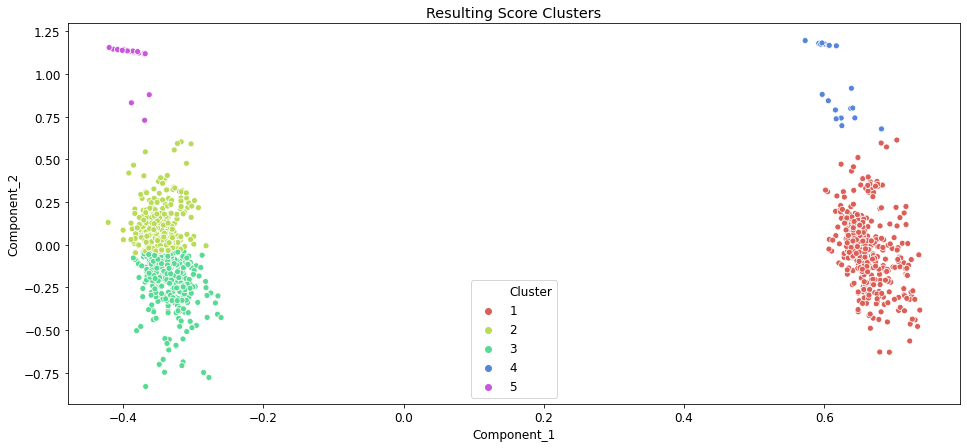

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,0,1,1.0,0.0
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,0,1,1.0,0.0
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,1,0,1.0,0.0
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,1,0,1.0,0.0
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z958018,55.0,2.0,NaN,NaN,20.0,45.0,20.0,29.0,20.0,1.97,...,1.000000,0.450000,1.250000,2.250000,44.0,2.250000,0,0,NaN,NaN
Z958018,55.0,2.0,NaN,NaN,6.0,43.0,19.0,30.0,20.0,3.20,...,0.300000,0.542169,4.000000,2.250000,44.0,7.500000,0,0,NaN,NaN
Z958018,55.0,2.0,NaN,NaN,12.0,47.0,26.0,35.0,32.0,0.93,...,0.375000,0.450000,1.750000,1.406250,32.0,3.750000,0,0,NaN,NaN


In [10]:
hemoDF, descSummary = runClustering(clusterModel=clusterModel, data=data, origData=hemoOrig, labels=hemoLabels, 
                                    modelName=hemoModelName, columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
hemoDF

In [11]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [1, 0, 4, 2, 3]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.448087,4,0.552083,4,0.145833,3,3.666667
1,0.460274,5,0.647059,5,0.205882,4,4.666667
2,0.361032,3,0.517241,3,0.137931,1,2.333333
3,0.350000,1,0.500000,2,0.142857,2,1.666667
4,0.357143,2,0.407407,1,0.222222,5,2.666667


In [12]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[4, 5, 2, 1, 3]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.448087,4,0.552083,4,0.145833,3,3.666667,4
1,0.460274,5,0.647059,5,0.205882,4,4.666667,5
2,0.361032,3,0.517241,3,0.137931,1,2.333333,2
3,0.350000,1,0.500000,2,0.142857,2,1.666667,1
4,0.357143,2,0.407407,1,0.222222,5,2.666667,3


In [13]:
#Save separate datasets
escIndx = sorted(list(set(escapeHemo.index)))
escH = hemoDF.loc[escIndx,:]

escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_Hemo.csv")
escH

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,4,4,4,3
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,4,4,4,3
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,5,5,5,4
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,5,5,5,4
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,5,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,3,2,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,2,3,3,1
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,2,3,3,1


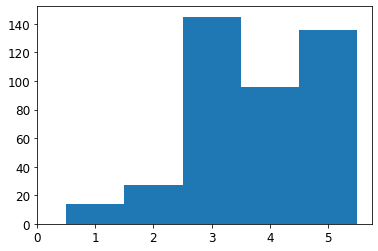

In [14]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(escH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [15]:
shockIndx = sorted(list(set(cardShockHemo.index)))
csH = hemoDF.loc[shockIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv")
csH

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
Z1017923,62.0,1.0,NaN,22.5,9.0,38.0,20.0,26.0,15.0,7.50,...,0.600000,0.313131,2.000000,2.066667,56.0,3.444444,2,3,3,1
Z1024990,59.0,1.0,NaN,17.5,12.0,51.0,33.0,39.0,31.0,5.67,...,0.387097,0.608696,1.500000,2.258065,25.0,5.833333,2,3,3,1
Z104044,65.0,1.0,NaN,NaN,12.0,61.8,21.6,36.6,26.0,4.13,...,0.461538,NaN,3.350000,2.038462,40.0,4.416667,2,3,3,1
Z1099417,37.0,2.0,NaN,27.5,32.0,58.0,34.0,44.0,21.0,3.39,...,1.523810,0.369369,0.750000,1.952381,30.0,1.281250,4,4,4,3
Z1140320,61.0,2.0,NaN,27.5,19.0,54.0,24.0,38.0,36.0,3.27,...,0.527778,0.430233,1.578947,1.027778,32.0,1.947368,4,4,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z928524,51.0,1.0,NaN,15.0,16.0,85.0,29.0,50.0,24.0,7.13,...,0.666667,NaN,3.500000,1.916667,55.0,2.875000,2,3,3,1
Z928524,51.0,1.0,NaN,27.5,21.0,62.0,32.0,42.0,23.0,2.03,...,0.913043,0.848485,1.428571,2.434783,38.0,2.666667,5,5,5,4
Z928524,51.0,1.0,NaN,27.5,23.0,67.0,35.0,45.0,21.0,4.20,...,1.095238,0.543689,1.391304,2.666667,40.0,2.434783,2,3,3,1


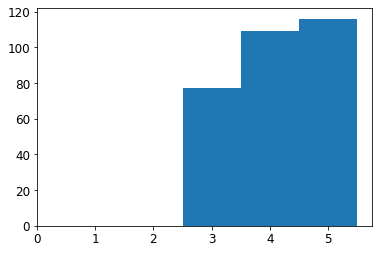

In [16]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [17]:
serialIndx = sorted(list(set(serialHemo.index)))
csH = hemoDF.loc[serialIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv")
csH

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
Z103426,49.0,2.0,NaN,17.5,25.5,53.750000,31.500000,40.25,25.333333,2.950,...,1.006579,0.365217,0.872549,1.657895,35.666667,1.647059,4,4,4,3
Z103426,49.0,2.0,NaN,17.5,15.0,42.333333,26.333333,33.00,21.400000,3.800,...,0.700935,0.368421,1.066667,1.962617,39.600000,2.800000,4,4,4,3
Z103697,56.0,2.0,NaN,22.5,24.0,67.000000,36.000000,48.00,36.000000,2.990,...,0.666667,NaN,1.291667,0.805556,26.000000,1.208333,4,4,4,3
Z103697,56.0,2.0,NaN,22.5,17.0,55.000000,23.000000,39.00,28.000000,3.710,...,0.607143,NaN,1.882353,1.035714,34.000000,1.705882,4,4,4,3
Z1050590,52.0,2.0,NaN,67.5,14.0,94.500000,36.000000,58.50,11.500000,4.685,...,1.217391,NaN,4.178571,NaN,NaN,NaN,4,4,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z958018,55.0,2.0,NaN,NaN,20.0,45.000000,20.000000,29.00,20.000000,1.970,...,1.000000,0.450000,1.250000,2.250000,44.000000,2.250000,4,4,4,3
Z958018,55.0,2.0,NaN,NaN,6.0,43.000000,19.000000,30.00,20.000000,3.200,...,0.300000,0.542169,4.000000,2.250000,44.000000,7.500000,4,4,4,3
Z958018,55.0,2.0,NaN,NaN,12.0,47.000000,26.000000,35.00,32.000000,0.930,...,0.375000,0.450000,1.750000,1.406250,32.000000,3.750000,4,4,4,3


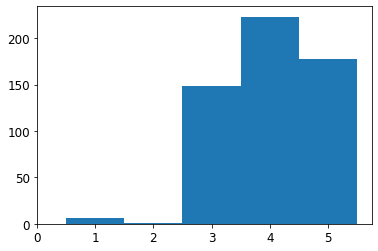

In [18]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

# ALL DATA

In [19]:
# first - try other clustering methods
allD = copy.deepcopy(allDataOrig)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

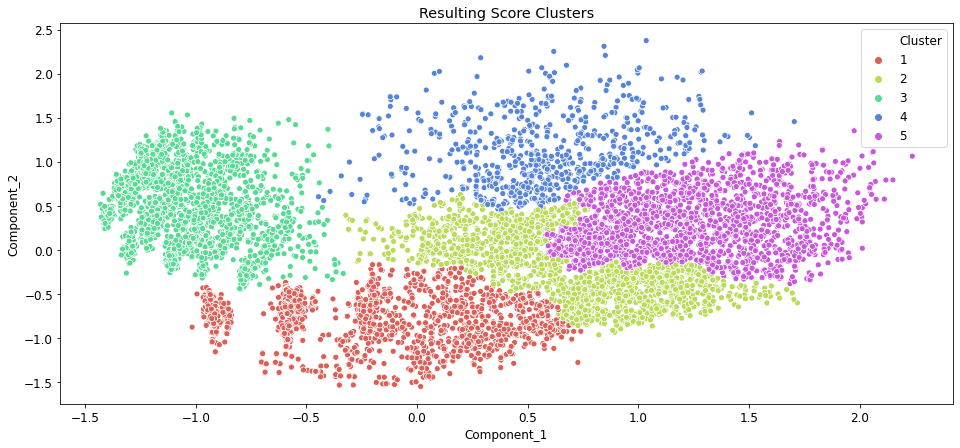

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,3,1,1.0,0.0
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,3,1,1.0,0.0
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,3,0,1.0,0.0
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,3,0,1.0,0.0
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99676,74.0,1.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,0,0,0.0,NaN
99887,60.0,2.0,2.0,76.204300,24.105394,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,190.666667,44.0,0.333333,0.463158,1,0,0.0,NaN
99887,60.0,2.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,0,0,0.0,NaN


In [20]:
allDataDF, descSummary = runClustering(clusterModel=clusterModel, data=data, origData=allDataOrig, labels=allDataLabels, 
                                    modelName=allDataModelName, columns=['MAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [21]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [2, 3, 0, 1, 4]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.389809,5,0.321705,3,0.016807,1,3.000000
1,0.167581,1,0.268739,2,0.063138,3,2.000000
2,0.319393,4,0.630137,5,0.125000,4,4.333333
3,0.275708,3,0.579732,4,0.174397,5,4.000000
4,0.204812,2,0.254695,1,0.050794,2,1.666667


In [22]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[3, 2, 5, 4, 1]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.389809,5,0.321705,3,0.016807,1,3.000000,3
1,0.167581,1,0.268739,2,0.063138,3,2.000000,2
2,0.319393,4,0.630137,5,0.125000,4,4.333333,5
3,0.275708,3,0.579732,4,0.174397,5,4.000000,4
4,0.204812,2,0.254695,1,0.050794,2,1.666667,1


In [23]:
#Save separate datasets
escIndx = sorted(list(set(escapeAllData.index)))
escH = allDataDF.loc[escIndx,:]

escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AllData.csv")
escH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
72.0,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,4,3,4,5
72.0,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,4,3,4,5
72.0,37.0,2.0,0.0,64.863709,0.000000,0.0,0.0,3.0,0.0,1.0,...,0.0,0.000000,118.000000,28.0,0.341463,0.411765,5,4,5,4
81.0,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,4,3,4,5
81.0,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,4,3,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302.0,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,4,3,4,5
99912.0,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,2,1,2,3
99912.0,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,2,1,2,3


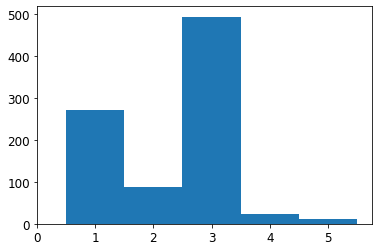

In [24]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(escH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [25]:
guIndx = sorted(list(set(guideAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv")
guH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
11.0,77.0,1.0,0.0,74.389149,0.000000,0.0,0.0,3.0,0.0,1.0,...,0.0,0.0,165.333333,52.0,0.433333,0.812500,5,4,5,4
11.0,57.0,2.0,2.0,88.905017,33.643189,0.0,70.0,3.0,0.0,0.0,...,0.0,0.0,148.000000,33.0,0.323529,0.375000,1,2,1,2
11.0,57.0,2.0,2.0,91.172066,0.000000,0.0,70.0,3.0,0.0,0.0,...,0.0,0.0,147.000000,32.0,0.316832,0.363636,2,1,2,3
350.0,54.0,1.0,0.0,65.317301,0.000000,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,166.000000,26.0,0.236364,0.232143,5,4,5,4
350.0,58.0,1.0,2.0,128.300000,39.449435,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,221.666667,45.0,0.298013,0.548780,4,3,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99676.0,74.0,1.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,3,5,3,1
99887.0,60.0,2.0,2.0,76.204300,24.105394,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,190.666667,44.0,0.333333,0.463158,2,1,2,3
99887.0,60.0,2.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,3,5,3,1


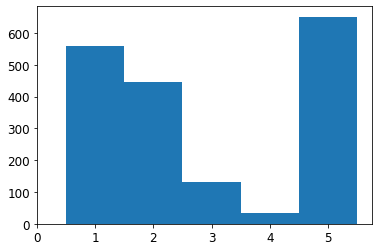

In [26]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [ ]:
guIndx = sorted(list(set(hfactionAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv")
guH

In [ ]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [ ]:
guIndx = sorted(list(set(bestAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/BEST/Preprocessed Data/BEST_AllData.csv")
guH

In [ ]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [ ]:
csIndx = sorted(list(set(cardShockAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv")
csH

In [ ]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [ ]:
csIndx = sorted(list(set(serialAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv")
csH

In [ ]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
b'HFACT00001',62.0,2.0,1.0,78.0,25.18,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,146.666667,30.0,0.300000,0.428571,2,1,2,3
b'HFACT00002',75.0,2.0,2.0,68.0,22.96,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,150.000000,30.0,0.294118,0.250000,2,1,2,3
b'HFACT00003',69.0,2.0,1.0,80.0,24.14,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,176.666667,40.0,0.327869,0.487805,1,2,1,2
b'HFACT00004',45.0,2.0,1.0,114.0,32.35,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,161.333333,28.0,0.259259,0.378378,1,2,1,2
b'HFACT00005',75.0,2.0,1.0,106.0,30.87,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,151.333333,38.0,0.358491,0.603175,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'HFACT02135',60.0,2.0,1.0,95.0,32.89,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,186.666667,70.0,0.500000,0.752688,2,1,2,3
b'HFACT02136',63.0,2.0,1.0,97.0,27.60,0.0,0.0,3.0,0.0,1.0,...,0.0,0.0,130.000000,30.0,0.333333,0.454545,1,2,1,2
b'HFACT02137',62.0,2.0,2.0,91.0,26.52,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,188.666667,42.0,0.323077,0.560000,1,2,1,2


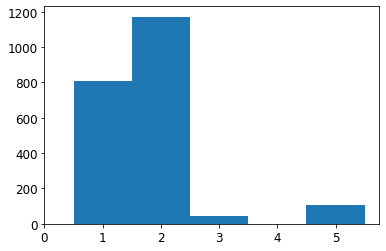

In [28]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [29]:
guIndx = sorted(list(set(bestAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/BEST/Preprocessed Data/BEST_AllData.csv")
guH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
1.0,73.0,2.0,0.0,50.348753,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,176.666667,60.0,0.461538,0.882353,5,4,5,4
2.0,72.0,1.0,0.0,77.110703,0.0,0.0,0.0,3.0,0.0,1.0,...,0.0,0.0,181.666667,40.0,0.320000,0.571429,5,4,5,4
3.0,58.0,1.0,0.0,94.800805,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,172.666667,36.0,0.305085,0.375000,5,4,5,4
4.0,42.0,1.0,0.0,134.716934,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,201.666667,35.0,0.259259,0.555556,5,4,5,4
5.0,58.0,1.0,0.0,70.306817,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,180.333333,62.0,0.466165,0.873239,5,4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704.0,60.0,1.0,0.0,86.182550,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,133.333333,25.0,0.277778,0.403226,5,4,5,4
2705.0,67.0,1.0,0.0,77.110703,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,220.000000,70.0,0.437500,0.921053,5,4,5,4
2706.0,78.0,2.0,0.0,45.812829,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,160.666667,54.0,0.457627,0.750000,5,4,5,4


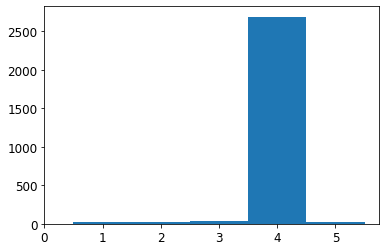

In [30]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [31]:
csIndx = sorted(list(set(cardShockAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv")
csH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
Z1002839,58.0,1.0,0.0,0.0,NaN,6.0,6.0,0.0,0.0,0.0,...,0.0,0.0,123.666667,42.0,0.461538,0.451613,3,5,3,1
Z1002839,58.0,1.0,0.0,0.0,NaN,NaN,6.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,3,5,3,1
Z1002839,58.0,1.0,0.0,0.0,NaN,NaN,6.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,3,5,3,1
Z101592,79.0,1.0,0.0,0.0,19.3,6.0,17.0,0.0,0.0,0.0,...,0.0,0.0,136.000000,46.0,0.460000,0.380165,3,5,3,1
Z101592,79.0,1.0,0.0,0.0,18.3,3.0,17.0,0.0,0.0,0.0,...,0.0,0.0,124.666667,38.0,0.422222,0.316667,3,5,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z964794,61.0,1.0,0.0,0.0,NaN,5.0,33.0,0.0,0.0,0.0,...,0.0,0.0,134.666667,33.0,0.351064,0.358696,3,5,3,1
Z964794,61.0,1.0,0.0,0.0,28.0,13.0,33.0,0.0,0.0,0.0,...,0.0,0.0,129.000000,34.0,0.373626,0.253731,3,5,3,1
Z977261,47.0,2.0,0.0,0.0,38.6,7.0,7.0,0.0,0.0,0.0,...,0.0,0.0,148.666667,57.0,0.508929,0.527778,3,5,3,1


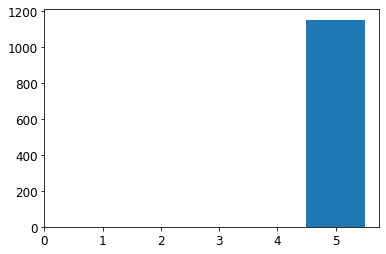

In [32]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [33]:
csIndx = sorted(list(set(serialAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv")
csH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
Z103426,49.0,2.0,0.0,0.0,24.2,83.0,83.0,0.0,0.0,0.0,...,0.0,0.0,143.666667,42.0,0.407767,0.666667,3,5,3,1
Z103426,49.0,2.0,0.0,0.0,NaN,NaN,83.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,3,5,3,1
Z103426,49.0,2.0,0.0,0.0,NaN,NaN,83.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,3,5,3,1
Z103697,56.0,2.0,0.0,0.0,NaN,12.0,16.0,0.0,0.0,0.0,...,0.0,0.0,132.333333,29.0,0.318681,0.216418,3,5,3,1
Z103697,56.0,2.0,0.0,0.0,NaN,4.0,16.0,0.0,0.0,0.0,...,0.0,0.0,144.666667,28.0,0.285714,0.184211,3,5,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z958018,55.0,2.0,0.0,0.0,16.1,14.0,30.0,0.0,0.0,0.0,...,0.0,0.0,151.666667,45.0,0.412844,0.266272,3,5,3,1
Z958018,55.0,2.0,0.0,0.0,19.1,2.0,30.0,0.0,0.0,0.0,...,0.0,0.0,117.666667,31.0,0.373494,0.191358,3,5,3,1
Z98220,46.0,1.0,0.0,0.0,27.1,4.0,16.0,0.0,0.0,0.0,...,0.0,0.0,187.333333,39.0,0.304688,0.286765,3,5,3,1


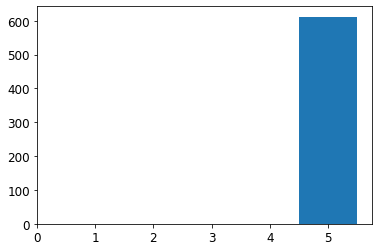

In [34]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()